In [1]:
import os, glob, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Import and Clean Speeches

In [2]:
# Speech corpus can be downloaded here: 
# http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus

In [3]:
# Create list of speech titles
speech_dir = "./president_speech_corpus/**/*.txt" # set directory where speeches are contained here

titles = []


for file in sorted(glob.glob(speech_dir)):
    title = open(file)
    title = title.readline()
    title = title[8:-3]
    titles.append(title)

In [4]:
# create list of president names

pres_names = []

for file in sorted(glob.glob(speech_dir)):
    pres_names.append(file)


pres_names2 = []

for count in range(len(pres_names)):
    pres_names2.append(pres_names[count].split('/')[3].split('_')[0])

In [5]:
'''list of speech dates - In the original txt files, there are 8 dates in the wrong place. You can identify the files
using pd.to_datetime(speech_dates, errors = "coerce"), which will set those speech dates to NaT (Not a Time). I
manually changed moved the dates in those files, since that was the simplest solution. May come back and write code
to grab those dates
'''

speech_dates = []
for file in sorted(glob.glob(speech_dir)):
    date = open(file)
    date.readline()
    date = date.readline()
    date = date[7:-3]
    speech_dates.append(date)

In [6]:
# list of full speeches

speeches = []

for file in sorted(glob.glob(speech_dir)):
    speech = open(file)
    speech = speech.read()
    speech = re.sub(r'<.*>', '', speech)
    speech = speech.replace('\n', ' ')
    speeches.append(speech)

In [7]:
# create speech dataframe (set to_datetime argument errors = "coerce" here to identify incorrectly dated files)
# LIST ISSUE FILES HERE

df = pd.DataFrame({'title' : titles, 'pres_name': pres_names2, 'speech' : speeches}, 
                  index = pd.to_datetime(speech_dates))

In [8]:
# Date filter

df = df[df.index.year >= 1900]

# filter press conferences and debates

# df = df[-df.title.str.contains('press', case = False)]
# df = df[-df.title.str.contains('debate', case = False)]

## Prepare words for NLP (tokenize, punctuation removal, stopwords)

In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.corpus import stopwords, wordnet

In [10]:
# lowercase

speeches = [sentence.lower() for sentence in df.speech]

In [11]:
# remove punctuation

word_tokenizer = RegexpTokenizer(r'\w+')

punc_remove = [word_tokenizer.tokenize(word) for word in speeches]

punc_remove = [' '.join(lst) for lst in punc_remove]

In [12]:
# add stopwords - changing this list can have a dramatic effect on results in the LDA model because it uses word
# counts, while NMF won't be affected much, since it uses TFIDF

stopwords = set(stopwords.words('english'))

extra_stopwords = ['people', 'united', 'states', 'america', 'american', 
                   'us', 'nation', 'great', 'one', 'would', 'great',
                  'government', 'upon', 'must', 'every', 'many', 'made', 
                   'may', 'also', 'shall', 'think', 'mr', 'know', 'want', 'without',
                  '000', 'years', 'year', 'believe', 'uh', 'going', 'make', 'americans', 'let',
                  'men', 'public', 'man', 'today', 'whereas', 'part', 'federal', 'hereby', 'last', 
                   'present', 'within', 'dr', 'mrs', 'therefore', 'aforesaid', 'could', 'things', 
                   'much', 'get', 'say', 'applause'
                  ]

stopwords.update(extra_stopwords)

# Additional stopwords that can impact results, but it can be argued that they are important words

# more_stopwords = ['world', 'new', 'country', 'president', 'said', 'day', 'republic', 'general', 'law',
#                  'laws', 'state', 'constitution', 'time', 'citizens', 'citizen', 'duty']

# stopwords.update(more_stopwords)



# split and rejoin list of strings to drop stopwords and retokenize

punc_remove = [' '.join(w for w in word.split() if w not in stopwords) for word in punc_remove]

punc_remove = [word_tokenizer.tokenize(word) for word in punc_remove]

# Run LDA Model

In [13]:
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel

In [14]:
# Build dictionary and bag of word corpus for LdaModel

dictionary = corpora.Dictionary(punc_remove)

corpus = [dictionary.doc2bow(text) for text in punc_remove]

(array([ 36.,  51.,  48.,  48.,  19., 120.,  66.,  75.,  57.,  65.]),
 array([693788. , 698019.1, 702250.2, 706481.3, 710712.4, 714943.5,
        719174.6, 723405.7, 727636.8, 731867.9, 736099. ]),
 <a list of 10 Patch objects>)

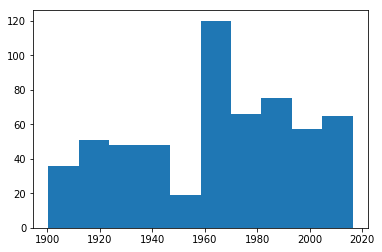

In [15]:
# Just a quick check on speech frequency. There is a low number of speeches in the 50s for some reason,
# and a spike in the 60s (TV became more widespread and the Civil Rights Movement and Vietnam were major issues)

# After the 60s, there were significantly more speeches recorded than previously

plt.hist(df.index)

In [16]:
# run LdaModel

ldamodel = LdaModel(corpus = corpus, num_topics=20, id2word = dictionary, 
                                           passes=50, random_state = 25)

In [17]:
# assign doc_topics

doc_topics = list(ldamodel.get_document_topics(corpus))

In [18]:
# Examine topic clusters

[x[1] for x in ldamodel.show_topics(num_topics = 20, num_words = 5)] # remove index to show all topic words

['0.016*"war" + 0.011*"vietnam" + 0.009*"peace" + 0.009*"south" + 0.007*"time"',
 '0.018*"tax" + 0.007*"unemployment" + 0.007*"ford" + 0.006*"investment" + 0.005*"nixon"',
 '0.007*"world" + 0.006*"president" + 0.005*"country" + 0.005*"soviet" + 0.004*"peace"',
 '0.005*"world" + 0.005*"khrushchev" + 0.005*"new" + 0.004*"freedom" + 0.004*"future"',
 '0.008*"president" + 0.007*"soviet" + 0.005*"gorbachev" + 0.005*"peace" + 0.005*"answer"',
 '0.005*"country" + 0.005*"law" + 0.004*"congress" + 0.004*"war" + 0.004*"national"',
 '0.027*"energy" + 0.025*"oil" + 0.008*"cuba" + 0.007*"schedule" + 0.006*"tariff"',
 '0.000*"time" + 0.000*"new" + 0.000*"country" + 0.000*"world" + 0.000*"war"',
 '0.036*"panama" + 0.014*"canal" + 0.013*"isthmus" + 0.011*"republic" + 0.010*"colon"',
 '0.016*"health" + 0.016*"care" + 0.010*"insurance" + 0.006*"system" + 0.006*"plan"',
 '0.014*"congress" + 0.006*"country" + 0.006*"tax" + 0.006*"bill" + 0.006*"program"',
 '0.008*"system" + 0.008*"business" + 0.007*"econo

In [19]:
# lda topic dataframe - create function from this to take number of topics and keywords

lda_results = [x[1] for x in ldamodel.show_topics(num_topics = 20, num_words = 5)]

lst = re.findall(r'([a-zA-Z]+)', str(lda_results))

lda_topic_list = [lst[x:x+5] for x in range(0, len(lst),5)]

lda_df = pd.DataFrame(lda_topic_list)

lda_df.index = [f'Topic {topic}' for topic in range(20)]

In [20]:
# LDA DF FOR GRAPHING TOPICS

# assign doc_topics to dataframe (list of list of tuples with percentage of each topic in each doc)

df['doc_topic'] = doc_topics

# convert to dictionary to easily access values

df['doc_topic'] = df['doc_topic'].map(lambda x: dict(x))

# Run NMF Model

### Non-Negative Matrix Factorization in sklearn for comparison to LDA

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [22]:
# Use CountVectorizer to get total word counts in documents

vectorizer = CountVectorizer(analyzer = "word", max_features = 10_000)

In [23]:
# Create list of strings from list of lists for CountVectorizer

punc_joined = [' '.join(text) for text in punc_remove]

In [24]:
# Transform words with TfidfTransformer - This takes into account term frequency across and within documents

word_counts = vectorizer.fit_transform(punc_joined)

tfidf_transform = TfidfTransformer(smooth_idf = False)

words_tfidf = tfidf_transform.fit_transform(word_counts)

# final_words = normalize(words_tfidf, norm = 'l1')

In [25]:
# Instantiate NMF model and fit to tfidf transformed documents

model = NMF(n_components = 20, init = 'nndsvd')

# Set W as the document by topic matrix
# Set H as the topic by word matrix

W = model.fit_transform(words_tfidf)
H = model.components_

In [26]:
# check matrix shapes

W.shape, H.shape

((585, 20), (20, 10000))

In [27]:
# Function to assign topic indices back to feature names - takes model, feature names from vectorizer, 
# and n_top_words as arguments. n_top_words selects the number of keywords per topic

def print_top_words(model, feature_names, n_top_words):
    lst = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        lst.append(message)
    return lst

In [28]:
# Set 3rd argument to number of topic keywords that are desired

topics_nmf = (print_top_words(model, vectorizer.get_feature_names(), 5))

In [29]:
# Check nmf topic assignment

topics_nmf

['Topic #0: world new nations free freedom',
 'Topic #1: law congress department commerce interstate',
 'Topic #2: health care jobs work new',
 'Topic #3: vietnam south vietnamese north peace',
 'Topic #4: iraq iraqi saddam iraqis kuwait',
 'Topic #5: soviet nuclear weapons missiles union',
 'Topic #6: president country got party republican',
 'Topic #7: war japanese german germany ships',
 'Topic #8: banks business credit industry employment',
 'Topic #9: viet nam south aggression ambassador',
 'Topic #10: tax budget inflation percent spending',
 'Topic #11: energy oil congress gas inflation',
 'Topic #12: peace nations world war peoples',
 'Topic #13: tariff cuba bill revision duties',
 'Topic #14: israel lebanon peace israeli palestinian',
 'Topic #15: negro law rights right negroes',
 'Topic #16: afghanistan qaeda terrorists terror al',
 'Topic #17: republic world civilization party nationality',
 'Topic #18: freedom god life day new',
 'Topic #19: panama canal isthmus colon republ

In [30]:
# Create a dataframe from nmf topics and keywords

nmfsplit = [item.split() for item in topics_nmf]

nmf_df = pd.DataFrame(nmfsplit)

nmf_df.index = [f'Topic {topic}' for topic in range(20)]

nmf_df.drop(columns = [0, 1], inplace = True)

nmf_df.columns = [1, 2, 3, 4, 5]

In [31]:
# write to csv if desired

# nmf_df.to_csv('nmf_topics')

In [32]:
# copy corpus df

corpus_df = df[df.columns[0:4]].copy()

In [33]:
# create NMF DataFrame for graphing

lsi_df = pd.DataFrame(W)

lsi_df.columns = ["topic_%d" % col for col in lsi_df.columns]

lsi_df = pd.concat([corpus_df.reset_index(), lsi_df], axis=1)

lsi_df.head()

,index,title,pres_name,speech,doc_topic,topic_0,topic_1,topic_2,topic_3,topic_4,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,1988-09-25,Debate with Michael Dukakis,bush,I think we've seen a deterioration of ...,"{2: 0.3027503, 10: 0.04934066, 19: 0.64316326}",0.000000,0.000000,0.077110,0.000000,0.005438,...,0.040443,0.000000,0.000000,0.0,0.000000,0.0,0.001228,0.0,0.011348,0.010505
1,1989-01-20,Inaugural Address,bush,"Mr. Chief Justice, Mr. President, Vice Presi...","{2: 0.039600223, 9: 0.08852721, 17: 0.21697919...",0.029247,0.002623,0.042639,0.023209,0.000000,...,0.000000,0.006828,0.014450,0.0,0.000000,0.0,0.000000,0.0,0.237960,0.000000
2,1988-08-18,Acceptance Speech at the Republican National C...,bush,I have many friends to thank tonight. I than...,"{17: 0.07929415, 18: 0.12963656, 19: 0.7887595}",0.000000,0.000000,0.100386,0.000000,0.009867,...,0.014337,0.030926,0.011483,0.0,0.005019,0.0,0.004094,0.0,0.177056,0.000000
3,1989-12-20,Address to the Nation on Panama,bush,"My fellow citizens, last night I ordered U. ...","{0: 0.07677447, 2: 0.4519084, 8: 0.123605825, ...",0.000000,0.000000,0.000000,0.000000,0.006316,...,0.000000,0.000000,0.000000,0.0,0.000665,0.0,0.024547,0.0,0.009812,0.483794
4,1989-05-12,Commencement Address at Texas A and M University,bush,"Thank you, Governor. Thank you all very much...","{2: 0.07152886, 9: 0.2906991, 17: 0.17870894, ...",0.000000,0.000682,0.016653,0.000364,0.000000,...,0.000000,0.000000,0.018327,0.0,0.000000,0.0,0.006018,0.0,0.059821,0.001857


In [34]:
# Create a column for the largest topic value from NMF results

lsi_df.index = lsi_df['index']

lsi_df = lsi_df.drop(columns = ['index'])

lsi_df.index = pd.to_datetime(lsi_df.index)

lsi_df['max_topic'] = lsi_df.loc[:, 'topic_0' : 'topic_19'].idxmax(axis=1)

In [35]:
# nmf topic sum - these will not sum to 1, since they are not percentage of doc based like LDA topics

# lsi_df['sum_topic'] = lsi_df.loc[:, 'topic_0' : 'topic_19'].sum(axis=1)

## Graphing

### Graphing Topics over Time

In [36]:
# graphing function for NMF results - can uncomment color and label to add arguments to graphing function

def graph_lsi(topic_num): #, color, label):
    
    plt.figure(figsize = (12, 8))
    plt.title(f'Topic Number {topic_num}')
    plt.ylabel('Percentage of Speech on Topic', fontsize = 16)
    plt.xlim(pd.Timestamp('1900-01-01'), pd.Timestamp('2018-01-01'))
    plt.ylim(0, .5)
    plt.vlines(x = lsi_df.index, ymin = 0, ymax = lsi_df[f'topic_{topic_num}'], alpha = .3, )#color = color, label = label)

In [37]:
# graphing function for LDA results

def graph_topic(topic_num):
    
    df[f'topic_{topic_num}'] = df['doc_topic'].apply(lambda x: x.get(topic_num, 0))
    
    plt.figure(figsize = (12, 8))
    plt.title(f'Topic Number {topic_num}')
    plt.ylabel('Percentage of Speech on Topic', fontsize = 16)
    plt.xlim(pd.Timestamp('1900-01-01'), pd.Timestamp('2018-01-01'))
    plt.ylim(0, 1)
    plt.vlines(x = df.index, ymin = 0, ymax = df[f'topic_{topic_num}'], alpha = .3)

##### LDA Graphs

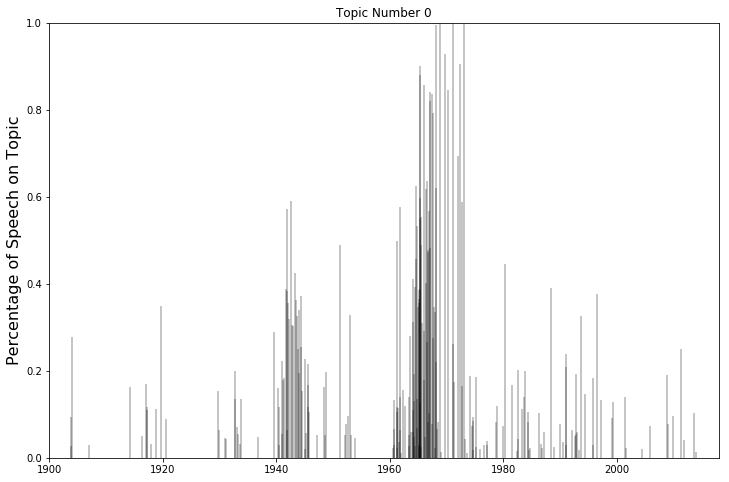

In [38]:
graph_topic(0)

In [39]:
#for x in range(20):
#    graph_topic(x)

##### NMF Graphs

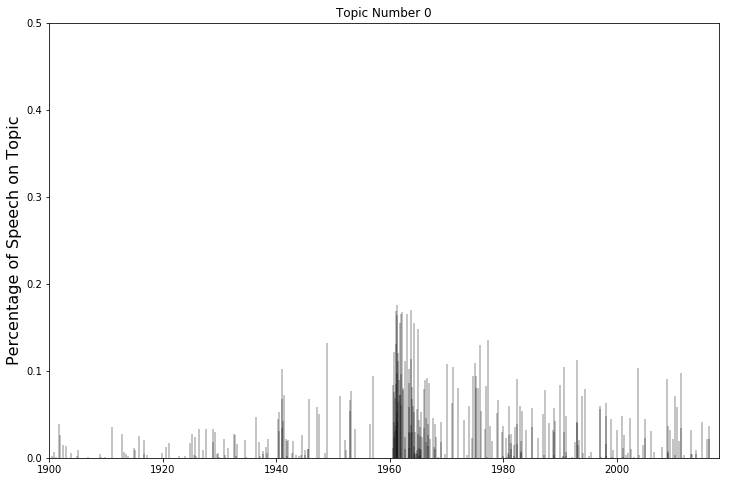

In [40]:
graph_lsi(0)

In [41]:


#colors = ['yellow', 'orange', 'green', 'blue', 'yellow', 'red']
#labels = ['Vietnam', 'Iraq + Afghanistan', 'Cold War', 'WW2', 'Vietnam', 'WW1']

#plt.figure(figsize = (12, 8))
#plt.title('20th Century US Wars Modeled with NMF', fontsize = 20)

#for color, topic in enumerate([3, 4, 5, 7, 9, 18]):
#    graph_lsi(topic, colors[color], labels[color])
    
#plt.legend()

In [42]:
# cmap = cm.get_cmap(name='hsv')

# Doc2vec Analysis

In [43]:
documents = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(punc_remove)]

In [44]:
docvec_model = Doc2Vec(documents = documents, vector_size=500,
                                      window=10, min_count=5, workers=2, seed=42, epochs = 20)

In [45]:
vecs = [doc for doc in docvec_model.docvecs.vectors_docs]

In [46]:
ldamodel.show_topics(num_topics = 20, num_words = 20) # remove index to show all topics

[(0,
  '0.016*"war" + 0.011*"vietnam" + 0.009*"peace" + 0.009*"south" + 0.007*"time" + 0.006*"president" + 0.005*"world" + 0.005*"north" + 0.005*"forces" + 0.004*"military" + 0.004*"country" + 0.004*"fighting" + 0.004*"viet" + 0.004*"vietnamese" + 0.004*"nam" + 0.004*"day" + 0.004*"nations" + 0.003*"take" + 0.003*"tonight" + 0.003*"enemy"'),
 (1,
  '0.018*"tax" + 0.007*"unemployment" + 0.007*"ford" + 0.006*"investment" + 0.005*"nixon" + 0.005*"help" + 0.004*"percent" + 0.004*"work" + 0.004*"system" + 0.004*"unemployed" + 0.004*"new" + 0.004*"rate" + 0.004*"revenue" + 0.004*"well" + 0.004*"growth" + 0.003*"need" + 0.003*"ought" + 0.003*"depreciation" + 0.003*"structure" + 0.003*"efficient"'),
 (2,
  '0.007*"world" + 0.006*"president" + 0.005*"country" + 0.005*"soviet" + 0.004*"peace" + 0.004*"well" + 0.004*"time" + 0.003*"war" + 0.003*"union" + 0.003*"first" + 0.003*"congress" + 0.003*"new" + 0.003*"defense" + 0.003*"good" + 0.003*"said" + 0.002*"security" + 0.002*"hope" + 0.002*"come" 

In [47]:
docvec_model.wv.most_similar('economy', topn = 20)

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('recession', 0.5719043612480164),
 ('inflationary', 0.5476022362709045),
 ('viable', 0.5046334266662598),
 ('deficit', 0.49715757369995117),
 ('revive', 0.4938308000564575),
 ('protectionism', 0.48406675457954407),
 ('pace', 0.4836490750312805),
 ('investing', 0.4677943289279938),
 ('mismanagement', 0.46149706840515137),
 ('expanding', 0.4587840735912323),
 ('structure', 0.45374298095703125),
 ('spur', 0.4519073963165283),
 ('finances', 0.4513145983219147),
 ('suffers', 0.4496876299381256),
 ('sapped', 0.44918501377105713),
 ('stewards', 0.44460195302963257),
 ('strongest', 0.4432305693626404),
 ('expansion', 0.4412615895271301),
 ('economies', 0.4383411705493927),
 ('productivity', 0.4343033730983734)]

In [48]:
docvec_model.wv.most_similar('iraq', topn = 20)

[('iraqi', 0.7053860425949097),
 ('kuwait', 0.6768907308578491),
 ('afghanistan', 0.6738117337226868),
 ('iraqis', 0.6373779773712158),
 ('hussein', 0.6347225904464722),
 ('saddam', 0.6240900754928589),
 ('qaeda', 0.5756035447120667),
 ('coalition', 0.5660409927368164),
 ('afghan', 0.5649160742759705),
 ('baghdad', 0.5559142827987671),
 ('taliban', 0.5412024259567261),
 ('al', 0.5350885391235352),
 ('terrorists', 0.5342772006988525),
 ('syrian', 0.5321261286735535),
 ('iran', 0.5293040871620178),
 ('qaida', 0.5247376561164856),
 ('assad', 0.5174956321716309),
 ('terrorism', 0.5157009959220886),
 ('dictator', 0.5128620862960815),
 ('syria', 0.5092694759368896)]

In [49]:
docvec_model.wv.most_similar('energy', topn = 20)

[('clean', 0.6513447165489197),
 ('oil', 0.6077816486358643),
 ('conservation', 0.5860788822174072),
 ('solar', 0.5783049464225769),
 ('sources', 0.5655242204666138),
 ('renewable', 0.5566893815994263),
 ('gas', 0.5507853031158447),
 ('fuels', 0.5318635702133179),
 ('dependence', 0.5208251476287842),
 ('fuel', 0.5099620819091797),
 ('fossil', 0.5020264983177185),
 ('cleaner', 0.4875386953353882),
 ('synthetic', 0.483209490776062),
 ('shale', 0.47692862153053284),
 ('shortage', 0.4763326644897461),
 ('gasoline', 0.47561344504356384),
 ('electricity', 0.4632377028465271),
 ('environmentally', 0.46173080801963806),
 ('harness', 0.45760154724121094),
 ('biofuels', 0.4526750147342682)]

In [50]:
# docvec_model.docvecs.doctags